In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json

from config import Cfg as cfg

import mysql.connector

%matplotlib inline

# Results data

In [2]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM results;"

# execute the query and assign it to a pandas dataframe
df_results = pd.read_sql(query, con=cnx)

cnx.close()

print("Number of single results:", len(df_results))
print("Number of individuals:", len(df_results.athlete.unique()))

Number of single results: 2000403
Number of individuals: 643055


# Races data

In [88]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM races;"
# execute the query and assign it to a pandas dataframe
df_races = pd.read_sql(query, con=cnx)

cnx.close()

print("Number of single races:", len(df_races))

Number of single races: 220


### Some processing on the datasets

In [89]:
# -----------
# -- RACES --
# -----------

# keep only active races
df_races = df_races.loc[df_races['info'].dropna().index]

# remove duplicates
df_races = df_races.loc[df_races.race != 'worldchampionship70.3m']

# remove worldchampionship as it's by qualification so people cannot really choose to do it
df_races = df_races.loc[df_races.race != 'worldchampionship70.3']
df_races = df_races.loc[df_races.race != 'worldchampionship']

# add Country codes
with open("./../data/geo-data/races_geo_info.json", 'r') as f:
    races_geo_info = json.loads(f.read())
             
df_races['country_code'] = None
for race in df_races.race.values:
    country_code = races_geo_info[race]
    df_races.loc[df_races.race == race, 'country_code'] = races_geo_info[race]['components']['ISO_3166-1_alpha-3']

# Add location info
races_locations = pd.read_csv("./../data/geo-data/races_lat_lon.csv")
df_races = df_races.merge(races_locations, left_on = 'race', right_on = 'race', how = 'left')

# Add info about type of race
# saving the races references for index
df_races['is_70.3'] = df_races['race'].str.contains('70.3')

# keep only columns of interest
df_races = df_races[['race', 'racename', 'is_70.3', 'region', 'country_code', 'lat', 'lon']]

# make the index the race name
df_races = df_races.set_index('race')

print("Number of single races:", len(df_races))

Number of single races: 157


In [90]:
# -----------
# -- RESULTS --
# -----------

# worldchampionship70.3 and worldchampionship70.3m are the same race
df_results.loc[df_results.race == "worldchampionship70.3m", 'race'] = 'worldchampionship70.3'

# keep only results of non discontinued races
df_results = df_results[df_results['race'].isin(df_races.index)]

# extract gender from division
df_results['gender'] = df_results['division'].apply(lambda x: x[0])

# convert date to datetime
df_results['date'] = pd.to_datetime(df_results['date'])

# str to int
df_results['year'] = df_results['year'].apply(int)

# # keep only results from before 2019
# df_results = df_results.loc[df_results['year'] < 2019]

# # discard pro athletes
# df_results = df_results.loc[df_results.division.str.contains("PRO") == False]

# Add gender
df_results['gender'] = None
df_results.loc[df_results['division'].str.contains("M"), 'gender'] = "M"
df_results.loc[df_results['division'].str.contains("F"), 'gender'] = "F"


print("Number of remaining single results:", len(df_results))
print("Number of remaining individuals:", len(df_results.athlete.unique()))
print("Number of races in results df:", len(df_results.race.unique()))

Number of remaining single results: 1674249
Number of remaining individuals: 591593
Number of races in results df: 157


# Filter results dataset to keep only prolific racers
#### To prevent cold-start problem keep only people with at least 3 different races.

In [91]:
min_unique_race_count = 5

# total number of races per athlete
athletes_count_races = (df_results.groupby('athlete')['division']
     .size()
     .reset_index()
     .rename(columns={'division': 'n_races'})
)

# total number of different races per athlete
athletes_count_diff_races = (df_results
     .groupby(['athlete', 'race'])
     .size()
     .reset_index()
     .groupby('athlete')
     .size()
     .reset_index()
     .rename(columns={0: 'n_different_races'})
)

# merge the two so we can filter from that
athlete_habits = athletes_count_diff_races.merge(athletes_count_races, left_on="athlete", right_on="athlete", how="left")

# What we are filtering with
max_count_races = 100 # probably similar names

valid_athletes = athlete_habits.loc[(athlete_habits['n_different_races']>=min_unique_race_count) & (athlete_habits['n_races']<=max_count_races)]

# use this df to filter original results data
df_results_filtered = df_results.loc[df_results['athlete'].isin(valid_athletes['athlete'])]
df_results_filtered = df_results_filtered.merge(valid_athletes, left_on="athlete", right_on="athlete", how="left")

# Anonimize entrants
user_hash = {}

for i,user in enumerate(df_results_filtered.athlete.unique()):
    user_hash[user] = f'u{i}'
df_results_filtered.loc[:, 'athlete'] = df_results_filtered.athlete.map(lambda x: user_hash[x])

print("Number of valid individuals:", len(valid_athletes))
print("Number of remaining single results:", len(df_results_filtered))
print("Number of races present in filtered results:", len(df_results_filtered.race.unique()))

Number of valid individuals: 52297
Number of remaining single results: 555730
Number of races present in filtered results: 157


### Update races df to only keep races present in filtered results df

In [92]:
df_races = df_races.loc[df_results_filtered.race.unique()]
print("Number of remaining races:", len(df_races))

Number of remaining races: 157


# Create dataframe with race count per athlete

In [8]:
results_races_count = (
    df_results_filtered
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
        .rename(columns={0: 'count'})
)

# Add demographics info for users (if we want to filter later)
gender = (df_results_filtered
     .groupby(['athlete', 'gender'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='gender', values='n')
     .idxmax(axis=1)
     .rename('gender')
)

country = (df_results_filtered
     .groupby(['athlete', 'country'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='country', values='n')
     .idxmax(axis=1)
     .rename('country')
)

results_races_count = results_races_count.merge(gender, left_on = 'athlete', right_on = 'athlete', how = 'left')
results_races_count = results_races_count.merge(country, left_on = 'athlete', right_on = 'athlete', how = 'left')

results_races_count.head()

,athlete,race,count,gender,country
0,u0,brazil,1,M,USA
1,u0,california70.3,1,M,USA
2,u0,cozumel,2,M,USA
3,u0,honu70.3,1,M,USA
4,u0,liuzhou70.3,1,M,USA


# For model evaluation

In [9]:
from sklearn.model_selection import train_test_split

full_set = results_races_count.copy()
train_set, test_set = train_test_split(full_set,
                                       stratify=full_set['athlete'], 
                                       test_size=0.20,
                                       random_state=42)

# set the athletes as index so we can get the items faster
full_set = full_set.set_index('athlete')
train_set = train_set.set_index('athlete')
test_set = test_set.set_index('athlete')

print(f'# results in Full set: {len(full_set)} ({len(full_set.index.unique())})')
print(f'# results in Train set: {len(train_set)} ({len(train_set.index.unique())})')
print(f'# results in Test set: {len(test_set)} ({len(test_set.index.unique())})')

# results in Full set: 381442 (52297)
# results in Train set: 305153 (52297)
# results in Test set: 76289 (52297)


# K Nearest Neighbor Model

## Let's create a class for handling KNN models

#### Reshaping the Data in the class initialization 

For K-Nearest Neighbors, we want the data to be in an m x n array, where m is the number of races and n is the number of athletes. To reshape the dataframe, we’ll pivot the dataframe to the wide format with races as rows and athletes as columns. Then we’ll fill the missing observations with 0s since we’re going to be performing linear algebra operations (calculating distances between vectors). Finally, we transform the values of the dataframe into a scipy sparse matrix for more efficient calculations.

In [10]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

class KNNrecommender:
    def __init__(self, full_set, train_set=None, binary=True, items_info_df=None, name='KNN model'):
        self.name = name
        self.full_set = full_set
        self.train_set = train_set if type(train_set) != type(None) else full_set
        self.items_df = self.train_set.reset_index().pivot(index='race', columns='athlete', values='count').fillna(0)
        self.binary = binary
        if binary:
            self.items_df = self.items_df.apply(np.sign)
        # convert to scipy sparse matrix
        self.items_matrix = csr_matrix(self.items_df.values)
        # make sure the items_info_df has the same order than the items_df
        if type(items_info_df) == type(None):
            self.items_info_df = pd.DataFrame(self.items_df.index, columns=['race'], index=self.items_df.index)
        else:
            self.items_info_df = items_info_df.loc[self.items_df.index]
            
    @staticmethod
    def get_filtered_items(df, filterByCol, valueToMatch, returnIndices=False):
        if not filterByCol:
            selection = df
        else:
            selection = df.loc[df[filterByCol] == valueToMatch]
        if returnIndices:
            return selection.index.map(lambda x: df.index.get_loc(x)).tolist()
        else:
            return selection.index.values
    
    def make_model(self, metric='cosine', algorithm='brute', n_neighbors=5, model_type='KNN', n_components=20):
        if model_type == 'KNN':
            self.model = NearestNeighbors(metric=metric, algorithm=algorithm, n_neighbors=n_neighbors)
            self.model.fit(self.items_matrix)
        elif model_type == 'SVD':
            X = self.items_df.values
            if not self.binary:
                # de-mean the data (normalize by each athlete mean) 
                X = X - np.mean(X, axis=0)
            SVD = TruncatedSVD(n_components=n_components, random_state=17)
            self.items_matrix = SVD.fit_transform(X)

            self.model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
            self.model.fit(self.items_matrix)
            
        return self.model
    
    def recommend(self, similarTo, topn=10, filterByCol=False, valueToMatch=False):
        try:
            self.model
        except:
            raise AttributeError("No model has been created yet!")
        query_index = np.where(self.items_df.index == similarTo)[0][0]
        total_n = self.items_df.shape[0]
        distances, indices = self.model.kneighbors(self.items_matrix[query_index].reshape(1, -1), n_neighbors=total_n)
        distances = distances.flatten()
        indices = indices.flatten()

        if filterByCol:
            selection_idx = self.get_filtered_items(self.items_info_df, filterByCol, valueToMatch, returnIndices=False)
            topn = topn if topn<len(selection_idx) else len(selection_idx)
            out_distances = []
            out_races = []

            for indice,distance in zip(indices, distances):
                race = self.items_info_df.index[indice]
                if ((race in selection_idx) and (race != similarTo)):
                    out_races.append(race)
                    out_distances.append(distance)
                    if len(out_distances) >= topn:
                        break
        else:
            out_races = self.items_info_df.index[indices[1:topn+1]] #remove the race itself
            out_distances = distances[1:topn+1] #remove the race itself

        out_df = self.items_info_df.loc[out_races]
        out_df['similarity'] = out_distances

        return out_df

# MODEL 1:  K Nearest Neighbor Model on binary matrix
### Assumption: if athletes interacted with a race, it's a sign the race is relevant to them

We’ll initialize the NearestNeighbors class as `knn_binary` and fit our sparse matrix to the instance. By specifying the `metric = 'cosine'`, the model will measure similarity bectween artist vectors by using cosine similarity.

## On sparse matrix (binary)

In [11]:
# initialize the model using the full data set
knn_binary = KNNrecommender(full_set, binary=True, items_info_df=df_races, name='KNN binary')
knn_binary.make_model(metric='cosine', algorithm='brute', n_neighbors=5)

# make recommendation
knn_binary.recommend('france70.3', topn=10)

,racename,is_70.3,region,country_code,lat,lon,similarity
race,,,,,,,
france,IRONMAN France,False,Europe,FRA,43.684857,7.241084,0.698354
vichy70.3,IRONMAN 70.3 Vichy,True,Europe,FRA,46.128845,3.414791,0.710333
switzerland70.3,IRONMAN 70.3 Switzerland,True,Europe,CHE,47.222923,8.830523,0.745443
luxembourg70.3,IRONMAN 70.3 Luxembourg - Région Moselle,True,Europe,LUX,49.551630,6.376436,0.748183
Nice70.3,IRONMAN 70.3 Nice,True,Europe,FRA,43.684918,7.241314,0.751376
mallorca70.3,IRONMAN 70.3 Mallorca,True,Europe,ESP,39.836211,3.124180,0.754694
barcelona70.3,IRONMAN 70.3 Barcelona,True,Europe,ESP,41.615767,2.671412,0.763061
vichy,IRONMAN Vichy,False,Europe,FRA,46.128894,3.414719,0.782932
italy70.3,IRONMAN 70.3 Italy,True,Europe,ITA,42.460235,14.229061,0.787401


## On sparse matrix (not binary)

In [12]:
# initialize the model using the full data set
knn_count = KNNrecommender(full_set, binary=False, items_info_df=df_races, name='KNN count')
knn_count.make_model(metric='cosine', algorithm='brute', n_neighbors=5)

# make recommendation
knn_count.recommend('france70.3', filterByCol="is_70.3", valueToMatch=False)

,racename,is_70.3,region,country_code,lat,lon,similarity
race,,,,,,,
france,IRONMAN France,False,Europe,FRA,43.684857,7.241084,0.628968
vichy,IRONMAN Vichy,False,Europe,FRA,46.128894,3.414719,0.773926
switzerland,IRONMAN Switzerland,False,Europe,CHE,47.359874,8.538704,0.818218
barcelona,IRONMAN Barcelona,False,Europe,ESP,41.618578,2.679928,0.852354
germany,IRONMAN European Championship Frankfurt,False,Europe,DEU,50.104698,8.684912,0.858875
emiliaromagna,IRONMAN Italy Emilia-Romagna,False,Europe,ITA,44.269994,12.353418,0.867563
austria,IRONMAN Austria-Kärnten,False,Europe,AUT,46.622768,14.255101,0.895512
lanzarote,IRONMAN Lanzarote,False,Europe,ESP,28.930279,-13.628128,0.897377
Maastricht,IRONMAN Maastricht - Limburg,False,Europe,NLD,50.840227,5.688756,0.910833


## With matrix factorization

In [13]:
# initialize the model using the full data set
knn_svd_25 = KNNrecommender(full_set, binary=True, items_info_df=df_races, name='KNN SVD 25')
knn_svd_25.make_model(metric='cosine', algorithm='brute', n_neighbors=5, model_type='SVD', n_components=25)

# make recommendation
knn_svd_25.recommend('france70.3', filterByCol="is_70.3", valueToMatch=False)

,racename,is_70.3,region,country_code,lat,lon,similarity
race,,,,,,,
vichy,IRONMAN Vichy,False,Europe,FRA,46.128894,3.414719,0.233817
emiliaromagna,IRONMAN Italy Emilia-Romagna,False,Europe,ITA,44.269994,12.353418,0.277874
france,IRONMAN France,False,Europe,FRA,43.684857,7.241084,0.305202
switzerland,IRONMAN Switzerland,False,Europe,CHE,47.359874,8.538704,0.352734
Maastricht,IRONMAN Maastricht - Limburg,False,Europe,NLD,50.840227,5.688756,0.420694
southafrica,IRONMAN African Championship South Africa,False,Africa,ZAF,-33.981828,25.658088,0.541749
tallinn,IRONMAN Tallinn,False,Europe,EST,59.441761,24.742291,0.586373
challengeroth,Challenge Roth,False,None,DEU,49.248751,11.121087,0.626269
haugesund,IRONMAN Haugesund,False,Europe,NOR,59.404009,5.281023,0.636656


# Locality-Sensitive Hashing (LSH)

In [14]:
from datasketch import MinHash, MinHashLSHForest

In [15]:
class LSHrecommender:
    def __init__(self, full_set, train_set=None, items_info_df=None, name='LSH model'):
        self.name = name
        self.full_set = full_set
        self.train_set = train_set if type(train_set) != type(None) else full_set
        # create hash
        self.items = self.train_set.reset_index().groupby('race').apply(lambda g: g['athlete'].values).to_dict()
        self.items_order = list(self.items.keys())
        # make sure the items_info_df has the same order than the items_df
        if type(items_info_df) == type(None):
            self.items_info_df = pd.DataFrame(np.array(self.items_order)[:, np.newaxis], columns=['race'], index=self.items_order)
        else:
            self.items_info_df = items_info_df.loc[self.items_order]
        self.n_permutations = 128

    def make_model(self, n_permutations=128):
        self.n_permutations = n_permutations
        minhash = []
    
        for race in self.items:
            athletes = self.items[race]
            m = MinHash(num_perm=n_permutations)
            for athlete in athletes:
                m.update(athlete.encode('utf8'))
            minhash.append(m)

        self.model = MinHashLSHForest(num_perm=n_permutations)

        for i,m in enumerate(minhash):
            self.model.add(i,m)

        self.model.index()

        return self.model
        
    def recommend(self, similarTo, topn=10):
        m = MinHash(num_perm=self.n_permutations)
        athletes = self.items[similarTo]
        for athlete in athletes:
            m.update(athlete.encode('utf8'))

        idx_array = np.array(self.model.query(m, topn+1))
        if len(idx_array) == 0:
            return None # if your query is empty, return none

        results = [race for race in np.array(self.items_order)[idx_array] if race != similarTo]

        return self.items_info_df.loc[results]

In [16]:
lsh_model = LSHrecommender(full_set, train_set, items_info_df=df_races, name='LSH model')

In [17]:
lsh_model.make_model(256)

In [18]:
lsh_model.recommend('france70.3', 10)

,racename,is_70.3,region,country_code,lat,lon
race,,,,,,
mallorca70.3,IRONMAN 70.3 Mallorca,True,Europe,ESP,39.836211,3.124180
copenhagen,IRONMAN Copenhagen,False,Europe,DNK,55.684076,12.592927
cozumel,IRONMAN Cozumel,False,North America,MEX,20.529076,-86.939496
salzburg70.3,IRONMAN 70.3 Zell am See-Kaprun,True,Europe,AUT,47.331958,12.803831
brazil,IRONMAN Brazil,False,South America,BRA,-27.443143,-48.490855
florida,IRONMAN Florida,False,North America,USA,30.150061,-85.762467
germany,IRONMAN European Championship Frankfurt,False,Europe,DEU,50.104698,8.684912
weymouth70.3,IRONMAN 70.3 Weymouth,True,Europe,GBR,50.617471,-2.448672
france,IRONMAN France,False,Europe,FRA,43.684857,7.241084


# Alternative Least Squares (ALS)

In [19]:
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

from sklearn.preprocessing import MinMaxScaler

import implicit

In [34]:
full_set_als = full_set.reset_index()[['athlete', 'race', 'count']]

# Converting the numbers to categories to be used for creating the categorical codes to avoid using long hash keys 
full_set_als['athlete'] = full_set_als['athlete'].astype("category")
full_set_als['race'] = full_set_als['race'].astype("category")

#cat.codes creates a categorical id for the users and artists
full_set_als['athlete_id'] = full_set_als['athlete'].cat.codes
full_set_als['race_id'] = full_set_als['race'].cat.codes

# The implicit library expects data as a item-user matrix so we
# create two matrices, one for fitting the model (item-user) 
# and one for recommendations (user-item)

sparse_item_user = sparse.csr_matrix((full_set_als['count'].astype(float), (full_set_als['race_id'], full_set_als['athlete_id'])))
sparse_user_item = sparse.csr_matrix((full_set_als['count'].astype(float), (full_set_als['athlete_id'], full_set_als['race_id'])))

In [35]:
matrix_size = sparse_user_item.shape[0]*sparse_user_item.shape[1] # Number of possible interactions in the matrix
num_raced = len(sparse_user_item.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_raced/matrix_size))
sparsity

95.35429015243534

We have very high sparsity in our data. This might not result in favorable results at the end. But one thing we can be sure of if finding similar races using the above data. As we will be having enough for each race based on the people that have raced them. Recommendations to the athletes might be less than expected

In [36]:
import random

def make_train(ratings, pct_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of item,user index into list

    
    random.seed(0) # Set the random seed to zero for reproducibility
    
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of item-user pairs without replacement

    item_inds = [index[0] for index in samples] # Get the item row indices

    user_inds = [index[1] for index in samples] # Get the user column indices

    
    training_set[item_inds, user_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user columns that were altered

In [37]:
# 20% of the data has been masked for this exercise
product_train, product_test, product_users_altered = make_train(sparse_item_user, pct_test = 0.05)

### Building the ALS model

In [38]:
# Initialize the als model and fit it using the sparse item-user matrix
# Parameters that we have chosen
# 1. factors = 20 -- Latent factors for user and item vectors
# 2. iterations = 20 -- Number of iterations to use while fitting the data
# 3. regularization = 0.1 -- regularization constant to be used in the cost function

model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=40)

# Calculate the confidence by multiplying it by our alpha value.(alpha value corresponds to the confidence metric 
# that we discussed earlier)

alpha_val = 15
data_conf = (product_train * alpha_val).astype('double')

# We have used an alpha_val of 15 after performing some iterations with different alpha values
#Fit the model
model.fit(data_conf)

100%|██████████| 40.0/40 [00:40<00:00,  1.01s/it]


### Bayesian personalized ranking
In this step ,we will be creating extracting the item_vector matrix and user_vector matrix that we have created through the model

In [39]:
item_vecs = model.item_factors
user_vecs = model.user_factors

In [40]:
print('Shape of Race vector matrix : ', item_vecs.shape)
print('Shape of Athlete vector matrix : ', user_vecs.shape)

Shape of Race vector matrix :  (157, 20)
Shape of Athlete vector matrix :  (52297, 20)


### Evaluating the recommendation system using AUC-ROC curve
The function below will help in evaluating our recommendation system by calculating the AUC - ROC curve

In [41]:
from sklearn import metrics

def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    
    - predictions: your prediction output
    
    - test: the actual target result you are comparing to
    
    returns:
    
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

In [42]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 1)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_column = training_set[:,user].toarray().reshape(-1) # Get the training set column
        zero_inds = np.where(training_column == 0) # Find where the interaction had not yet occurred
        
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[:,user].toarray()[zero_inds,0].reshape(-1)
        
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

In [43]:
calc_mean_auc(product_train, product_users_altered,
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], product_test)
# AUC for our recommender system

(0.843, 0.758)

We are actually getting a better AUC in terms of prediction of races for a user. But there are a couple of points that we need to consider there.

By calculating AUC, we are actually not considering the rank of the recommendation. Although, we might be predicting that the race, the race the athlete has done might not be present in the top 20 recommendations.
Because of the sparsity of the data, we can see that there will be a lot more True negatives than false positives effectively lowering the False positive rate. This also contributes to the increase in AUC.
Having said that, let's see how our model performs when it comes to identifying similar races and making recommendations to the athletes

### Example for recommendation

In [121]:
class ALSrecommender:
    def __init__(self, full_set, train_set=None, items_info_df=None, name="ALS model"):
        self.name = name
        self.full_set = full_set
        self.train_set = train_set if type(train_set) != type(None) else full_set
        self.items_df = self.train_set.reset_index()[['athlete', 'race', 'count']]
        # Converting the numbers to categories to be used for creating the categorical codes to avoid using long hash keys 
        self.items_df['athlete'] = self.items_df['athlete'].astype("category")
        self.items_df['race'] = self.items_df['race'].astype("category")
        #cat.codes creates a categorical id for the users and artists
        self.items_df['athlete_id'] = self.items_df['athlete'].cat.codes
        self.items_df['race_id'] = self.items_df['race'].cat.codes
        # The implicit library expects data as a item-user matrix so we
        # create two matrices, one for fitting the model (item-user) 
        # and one for recommendations (user-item)
        self.items_matrix = csr_matrix((self.items_df['count'].astype(float), (self.items_df['race_id'], self.items_df['athlete_id'])))
        # make sure the items_info_df has the same order than the items_df
        if type(items_info_df) == type(None):
            self.items_info_df = self.items_df[['race', 'race_id']].drop_duplicates()
            self.items_info_df = self.items_info_df.set_index('race')
        else:
            self.items_info_df = items_info_df.merge(self.items_df[['race', 'race_id']].drop_duplicates(), left_on='race', right_on='race', how='left')
            self.items_info_df = self.items_info_df.set_index('race')
            
    def make_model(self, factors=20, regularization=0.1, iterations=40, alpha=15):
        # Initialize the als model and fit it using the sparse item-user matrix
        # Parameters that we have chosen
        # 1. factors = 20 -- Latent factors for user and item vectors
        # 2. iterations = 20 -- Number of iterations to use while fitting the data
        # 3. regularization = 0.1 -- regularization constant to be used in the cost function

        self.model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=regularization, iterations=iterations)

        # Calculate the confidence by multiplying it by our alpha value.(alpha value corresponds to the confidence metric 
        # that we discussed earlier)
        data_conf = (self.items_matrix * alpha).astype('double')

        # We have used an alpha_val of 15 after performing some iterations with different alpha values
        #Fit the model
        self.model.fit(data_conf)
        
    def recommend(self, similarTo, topn=10):
        # get encoded categorical id of race
        race_id = self.items_info_df.loc[similarTo]['race_id']

        # Use implicit to get similar items.
        similar = self.model.similar_items(race_id, topn+1)[1:]
        out_distances = list(map(lambda x: x[1], similar))
        out_races = list(map(lambda x: self.items_info_df.loc[self.items_info_df['race_id'] == x[0]].index.values[0], similar))
        
        out_df = self.items_info_df.loc[out_races]
        out_df['similarity'] = out_distances

        return out_df

In [122]:
als_model = ALSrecommender(full_set, train_set, items_info_df=df_races, name=f'ALS model')
als_model.make_model(factors=20, regularization=0.1, iterations=40, alpha=15)                      


100%|██████████| 40.0/40 [00:38<00:00,  1.05it/s]


In [124]:
# als_model.items_info_df['race' = als_model.items_info_df.index
als_model.recommend('france70.3', 10)

,racename,is_70.3,region,country_code,lat,lon,race_id,similarity
race,,,,,,,,
vichy70.3,IRONMAN 70.3 Vichy,True,Europe,FRA,46.128845,3.414791,146,0.432532
Nice70.3,IRONMAN 70.3 Nice,True,Europe,FRA,43.684918,7.241314,7,0.418482
barcelona70.3,IRONMAN 70.3 Barcelona,True,Europe,ESP,41.615767,2.671412,20,0.378834
vichy,IRONMAN Vichy,False,Europe,FRA,46.128894,3.414719,145,0.290592
luxembourg70.3,IRONMAN 70.3 Luxembourg - Région Moselle,True,Europe,LUX,49.551630,6.376436,87,0.262203
switzerland70.3,IRONMAN 70.3 Switzerland,True,Europe,CHE,47.222923,8.830523,133,0.243498
france,IRONMAN France,False,Europe,FRA,43.684857,7.241084,58,0.206520
chattanooga,IRONMAN Chattanooga,False,North America,USA,35.063181,-85.287417,40,0.184227
mallorca70.3,IRONMAN 70.3 Mallorca,True,Europe,ESP,39.836211,3.124180,90,0.176119


## Evaluating the model

We'll use the **Mean Average Precision** at **K**

In [125]:
from utils.average_precision import mapk

In [126]:
class ModelEvaluator:
    def __init__(self, full_set, train_set, test_set, size):
        self.full_set = full_set
        self.train_set = train_set
        self.test_set = test_set
        self.requested_size = size
        self.users_sample = self.get_users_sample(n=size)
        self.users_interacted_items_in_train = [self.get_interacted_items_for_from(userId, self.train_set) for userId in self.users_sample]
        self.users_picked_race = [np.random.choice(races_in_train) for races_in_train in self.users_interacted_items_in_train]
        self.users_interacted_items_in_test = [self.get_interacted_items_for_from(userId, self.test_set) for userId in self.users_sample]

    @staticmethod
    def get_interacted_items_for_from(userId, dataset):
        interacted_items = dataset.loc[userId, 'race']
        return interacted_items.tolist() if type(interacted_items) == pd.Series else [interacted_items]
    
    def get_users_sample(self, n):
        return list(np.random.choice(np.unique(self.full_set.index), size=n, replace=False))

In [127]:
# let's test our model on 10000 randomly picked athletes
evaluator = ModelEvaluator(full_set, train_set, test_set, 2000)

In [128]:
# we'll create a popularity model that will output the most popular races
popularity = train_set.reset_index().groupby('race')['count'].sum().sort_values(ascending=False).reset_index()
popularity = popularity.set_index('race')

class PopularityModel:
    def __init__(self, popularity, name='popularity'):
        self.name = name
        self.popularity = popularity
        
    def recommend(self, race, n):
        return self.popularity.iloc[:n]
    
popularity_model = PopularityModel(popularity)

In [142]:
results = {}

# fit models on train set
knn_binary = KNNrecommender(full_set, train_set, binary=True, items_info_df=df_races, name='KNN binary')
knn_binary.make_model(metric='cosine', algorithm='brute', n_neighbors=5)
knn_count = KNNrecommender(full_set, train_set, binary=False, items_info_df=df_races, name='KNN count')
knn_count.make_model(metric='cosine', algorithm='brute', n_neighbors=5)
lsh_256 = LSHrecommender(full_set, train_set, items_info_df=df_races, name='LSH model 256')
lsh_256.make_model(256)
lsh_512 = LSHrecommender(full_set, train_set, items_info_df=df_races, name='LSH model 512')
lsh_512.make_model(512)
knn_svd = KNNrecommender(full_set, train_set, binary=False, items_info_df=df_races, name=f'KNN SVD 21')
knn_svd.make_model(metric='cosine', algorithm='brute', n_neighbors=5, model_type='SVD', n_components=21)
als_model = ALSrecommender(full_set, train_set, items_info_df=df_races, name=f'ALS model')
als_model.make_model(factors=10, regularization=0.1, iterations=50, alpha=20)
                         
# models list
models_to_test = [popularity_model, knn_count, knn_binary, lsh_256, lsh_512, lsh_1024, knn_svd, als_model] 
    
for model in models_to_test:
    # make recommendation
    races_recommended = [model.recommend(race, 20).index.tolist() for race in evaluator.users_picked_race]
    mapk_5_10_20 = [mapk(evaluator.users_interacted_items_in_test, races_recommended, k) for k in [5, 10, 20]]
    
    # store results
    results[model.name] = mapk_5_10_20
    print(f"Recommendations with the {model.name} model done!")
    
evaluation_results_df = pd.DataFrame(results, index=['MAP@5', 'MAP@10', 'MAP@20']).transpose()

100%|██████████| 50.0/50 [00:31<00:00,  1.58it/s]


Recommendations with the popularity model done!
Recommendations with the KNN count model done!
Recommendations with the KNN binary model done!
Recommendations with the LSH model 256 model done!
Recommendations with the LSH model 512 model done!
Recommendations with the LSH model 1024 model done!
Recommendations with the KNN SVD 21 model done!
Recommendations with the ALS model model done!


In [143]:
evaluation_results_df

,MAP@5,MAP@10,MAP@20
popularity,0.060266,0.074134,0.085532
KNN count,0.119841,0.143131,0.158821
KNN binary,0.129905,0.152196,0.168234
LSH model 256,0.044489,0.056453,0.067137
LSH model 512,0.039171,0.051894,0.062050
LSH model 1024,0.045889,0.059048,0.069150
KNN SVD 21,0.080650,0.097464,0.111622
ALS model,0.095047,0.111712,0.122204


In [145]:
als_model.model

In [147]:
import pickle
# save the model to disk
filename = './als-model.sav'
pickle.dump(als_model.model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.recommen(X_test, Y_test)

In [148]:
race_id = als_model.items_info_df.loc['france70.3']['race_id']

# Use implicit to get similar items.
similar = loaded_model.similar_items(race_id, 10)
similar

[(59, 0.3313097),
 (146, 0.3205595),
 (7, 0.3160128),
 (68, 0.2845827),
 (20, 0.2766896),
 (87, 0.2600407),
 (133, 0.25081438),
 (90, 0.24584988),
 (80, 0.24344717),
 (1, 0.23501675)]

### ALS number of factors

In [135]:
results = {}

models_to_test = []

for i in range(5, 51, 3):
    # fit models on train set
    als_model = ALSrecommender(full_set, train_set, items_info_df=df_races, name=f'ALS model {i}')
    als_model.make_model(factors=i, regularization=0.1, iterations=40, alpha=15)
    models_to_test.append(als_model)
     
for model in models_to_test:
    # make recommendation
    races_recommended = [model.recommend(race, 20).index.tolist() for race in evaluator.users_picked_race]
    mapk_5_10_20 = [mapk(evaluator.users_interacted_items_in_test, races_recommended, k) for k in [5, 10, 20]]
    
    # store results
    results[model.name] = mapk_5_10_20
    print(f"Recommendations with the {model.name} model done!")
    
evaluation_results_df = pd.DataFrame(results, index=['MAP@5', 'MAP@10', 'MAP@20']).transpose()

100%|██████████| 40.0/40 [00:18<00:00,  2.21it/s]
100%|██████████| 40.0/40 [00:20<00:00,  1.94it/s]
100%|██████████| 40.0/40 [00:28<00:00,  1.42it/s]
100%|██████████| 40.0/40 [00:29<00:00,  1.36it/s]
100%|██████████| 40.0/40 [00:39<00:00,  1.01it/s]
100%|██████████| 40.0/40 [00:41<00:00,  1.03s/it]
100%|██████████| 40.0/40 [00:41<00:00,  1.04s/it]
100%|██████████| 40.0/40 [00:50<00:00,  1.15s/it]
100%|██████████| 40.0/40 [00:55<00:00,  1.16s/it]
100%|██████████| 40.0/40 [00:45<00:00,  1.14s/it]
100%|██████████| 40.0/40 [00:46<00:00,  1.16s/it]
100%|██████████| 40.0/40 [00:52<00:00,  1.32s/it]
100%|██████████| 40.0/40 [01:02<00:00,  1.55s/it]
100%|██████████| 40.0/40 [00:51<00:00,  1.30s/it]
100%|██████████| 40.0/40 [00:53<00:00,  1.15s/it]
100%|██████████| 40.0/40 [00:55<00:00,  1.15s/it]


Recommendations with the ALS model 5 model done!
Recommendations with the ALS model 8 model done!
Recommendations with the ALS model 11 model done!
Recommendations with the ALS model 14 model done!
Recommendations with the ALS model 17 model done!
Recommendations with the ALS model 20 model done!
Recommendations with the ALS model 23 model done!
Recommendations with the ALS model 26 model done!
Recommendations with the ALS model 29 model done!
Recommendations with the ALS model 32 model done!
Recommendations with the ALS model 35 model done!
Recommendations with the ALS model 38 model done!
Recommendations with the ALS model 41 model done!
Recommendations with the ALS model 44 model done!
Recommendations with the ALS model 47 model done!
Recommendations with the ALS model 50 model done!


In [136]:
evaluation_results_df

,MAP@5,MAP@10,MAP@20
ALS model 5,0.086874,0.104690,0.119181
ALS model 8,0.095591,0.113382,0.126563
ALS model 11,0.096892,0.110777,0.121828
ALS model 14,0.087826,0.102128,0.111982
ALS model 17,0.083371,0.096332,0.105589
ALS model 20,0.077628,0.091350,0.099722
ALS model 23,0.068394,0.079580,0.087660
ALS model 26,0.070105,0.081754,0.089555
ALS model 29,0.064385,0.074700,0.082867
ALS model 32,0.059330,0.068765,0.075889


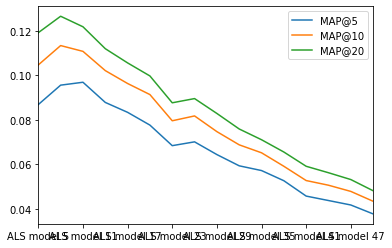

In [137]:
evaluation_results_df.plot()

### ALS confidence alpha

In [140]:
results = {}

models_to_test = []

for i in range(15, 31, 1):
    # fit models on train set
    als_model = ALSrecommender(full_set, train_set, items_info_df=df_races, name=f'ALS alpha {i}')
    als_model.make_model(factors=10, regularization=0.1, iterations=40, alpha=i)
    models_to_test.append(als_model)
     
for model in models_to_test:
    # make recommendation
    races_recommended = [model.recommend(race, 20).index.tolist() for race in evaluator.users_picked_race]
    mapk_5_10_20 = [mapk(evaluator.users_interacted_items_in_test, races_recommended, k) for k in [5, 10, 20]]
    
    # store results
    results[model.name] = mapk_5_10_20
    print(f"Recommendations with the {model.name} model done!")
    
evaluation_results_df = pd.DataFrame(results, index=['MAP@5', 'MAP@10', 'MAP@20']).transpose()

100%|██████████| 40.0/40 [00:28<00:00,  1.41it/s]
100%|██████████| 40.0/40 [00:26<00:00,  1.48it/s]
100%|██████████| 40.0/40 [00:27<00:00,  1.45it/s]
100%|██████████| 40.0/40 [00:25<00:00,  1.56it/s]
100%|██████████| 40.0/40 [00:25<00:00,  1.57it/s]
100%|██████████| 40.0/40 [00:25<00:00,  1.58it/s]
100%|██████████| 40.0/40 [00:25<00:00,  1.57it/s]
100%|██████████| 40.0/40 [00:25<00:00,  1.58it/s]
100%|██████████| 40.0/40 [00:26<00:00,  1.51it/s]
100%|██████████| 40.0/40 [00:26<00:00,  1.51it/s]
100%|██████████| 40.0/40 [00:26<00:00,  1.52it/s]
100%|██████████| 40.0/40 [00:26<00:00,  1.52it/s]
100%|██████████| 40.0/40 [00:27<00:00,  1.47it/s]
100%|██████████| 40.0/40 [00:28<00:00,  1.41it/s]
100%|██████████| 40.0/40 [00:27<00:00,  1.46it/s]
100%|██████████| 40.0/40 [00:27<00:00,  1.48it/s]


Recommendations with the ALS alpha 15 model done!
Recommendations with the ALS alpha 16 model done!
Recommendations with the ALS alpha 17 model done!
Recommendations with the ALS alpha 18 model done!
Recommendations with the ALS alpha 19 model done!
Recommendations with the ALS alpha 20 model done!
Recommendations with the ALS alpha 21 model done!
Recommendations with the ALS alpha 22 model done!
Recommendations with the ALS alpha 23 model done!
Recommendations with the ALS alpha 24 model done!
Recommendations with the ALS alpha 25 model done!
Recommendations with the ALS alpha 26 model done!
Recommendations with the ALS alpha 27 model done!
Recommendations with the ALS alpha 28 model done!
Recommendations with the ALS alpha 29 model done!
Recommendations with the ALS alpha 30 model done!


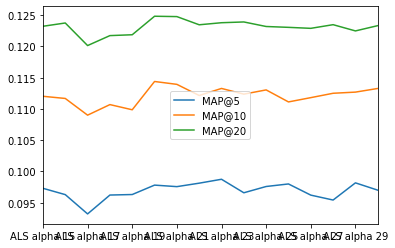

In [141]:
evaluation_results_df.plot()

In [404]:
results = {}

# fit models on train set
knn_binary = KNNrecommender(full_set, train_set, binary=True, items_info_df=df_races, name='KNN binary')
knn_binary.make_model(metric='cosine', algorithm='brute', n_neighbors=5)
knn_count = KNNrecommender(full_set, train_set, binary=False, items_info_df=df_races, name='KNN count')
knn_count.make_model(metric='cosine', algorithm='brute', n_neighbors=5)

# models list
models_to_test = [popularity_model, knn_count, knn_binary]

for binary in [True, False]:
    for n_components in range(1, 60):
        knn_svd = KNNrecommender(full_set, train_set, binary=binary, items_info_df=df_races, name=f'KNN SVD {"binary " if binary else ""}{n_components}')
        knn_svd.make_model(metric='cosine', algorithm='brute', n_neighbors=5, model_type='SVD', n_components=n_components)

        models_to_test.append(knn_svd)  
    
for model in models_to_test:
    # make recommendation
    races_recommended = [model.recommend(race, 20).index.tolist() for race in evaluator.users_picked_race]
    mapk_5_10_20 = [mapk(evaluator.users_interacted_items_in_test, races_recommended, k) for k in [5, 10, 20]]
    
    # store results
    results[model.name] = mapk_5_10_20
    print(f"Recommendations with the {model.name} model done!")
    
evaluation_results_df = pd.DataFrame(results, index=['MAP@5', 'MAP@10', 'MAP@20']).transpose()

Recommendations with the popularity model done!
Recommendations with the KNN count model done!
Recommendations with the KNN binary model done!
Recommendations with the KNN SVD binary 1 model done!
Recommendations with the KNN SVD binary 2 model done!
Recommendations with the KNN SVD binary 3 model done!
Recommendations with the KNN SVD binary 4 model done!
Recommendations with the KNN SVD binary 5 model done!
Recommendations with the KNN SVD binary 6 model done!
Recommendations with the KNN SVD binary 7 model done!
Recommendations with the KNN SVD binary 8 model done!
Recommendations with the KNN SVD binary 9 model done!
Recommendations with the KNN SVD binary 10 model done!
Recommendations with the KNN SVD binary 11 model done!
Recommendations with the KNN SVD binary 12 model done!
Recommendations with the KNN SVD binary 13 model done!
Recommendations with the KNN SVD binary 14 model done!
Recommendations with the KNN SVD binary 15 model done!
Recommendations with the KNN SVD binary 1

In [410]:
evaluation_results_df.head()

,MAP@5,MAP@10,MAP@20
popularity,0.061655,0.076176,0.088362
KNN count,0.183368,0.208122,0.222961
KNN binary,0.189607,0.213882,0.228756
KNN SVD binary 1,0.016957,0.018557,0.022327
KNN SVD binary 2,0.056493,0.072985,0.087996


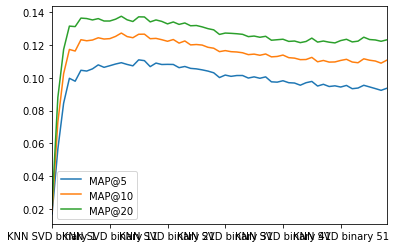

In [411]:
evaluation_results_df.loc[(evaluation_results_df.index.str.contains('SVD') & evaluation_results_df.index.str.contains('binary'))].plot()

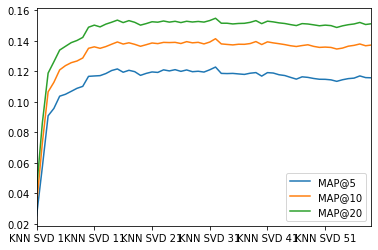

In [412]:
evaluation_results_df.loc[(evaluation_results_df.index.str.contains('SVD')) & (evaluation_results_df.index.str.contains('binary')==False)].plot()